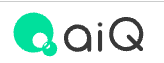

[disclaimer](../../disclaimer.txt/)

# aiQ DataHub: aiQ POS ELEC Goods Sample Evaluation Notebook

- aiQ POS Elec Goods is data that consolidates the sales of electronic products from electronics retailers and online shopping platforms, organized by TICKER.

In [1]:
# Evaluate the following command to update the custom module
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.io
import plotly.express as px
from aiq_strategy_robot.data.data_accessor import DAL

In [3]:
for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

if '../..' not in sys.path:
    sys.path.append('../..')
    
from libs.dataset import aiq_pos_elec_goods as sc_elec
from libs.dataset import common as sc_common
from libs.path import DEFAULT_DIR

- Create an instance of the standard data handler.
- The data handler is an object that holds libraries for data retrieval and data processing.

In [4]:
sdh = DAL()

## Step 2: Load Data to `sdh`
Since the focus here is on demonstrating data analysis, the data will be loaded through a simple loader that has been prepared separately.

In [5]:
sdh.extract.clear()

data_id_alt = sc_elec.register_elec_goods_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc_common.register_market(sdh, yf_switch=False, base_data_id=data_id_alt)
data_id_funda = sc_common.register_fundamental(sdh)
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,external,sample,Unknown,pos_elec_goods,"[1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...","[TICKER, DATETIME]",2009-01-01 00:00:00,2024-08-31 00:00:00
2,RawData,External,Unknown,Unknown,market_returns,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-08-30 00:00:00
3,RawData,External,Unknown,Unknown,funda,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[TICKER, DATETIME]",2007-04-20 00:00:00,2024-05-31 00:00:00


### Step 2.1: Identify Tickers with Consistently Available Daily Data
Identify TICKERs where `pos_sales` data is densely observed along the `datetime` axis, with a data density of at least the specified `lower_bound` ratio.

In [6]:
variable = 'pos_sales'
lower_bound = 0.9
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2023-12-31')

In [7]:
# Retrieve the pre-processed data that was registered in the standard data handler.
dfpos = sdh.get_raw_data(data_id_alt)

# Set the index to be a `DatetimeIndex` type with only the `DATETIME` column.
dfcheck = dfpos[[variable]].unstack('TICKER').droplevel(0, axis=1)
if start_date:
    dfcheck = dfcheck.loc[dfcheck.index > start_date]
if end_date:
    dfcheck = dfcheck.loc[dfcheck.index < end_date]
dfcheck.dropna(how='all', axis=1, inplace=True)

# Count the total number of dates.
num_obs = len(dfcheck)

# Count the number of non-NaN rows for each TICKER.
dfcount = dfcheck.count()

# Calculate the percentage of non-NaN rows for each TICKER.
list_dense_tickers = dfcount.loc[dfcount / num_obs > lower_bound].index.tolist()

print(f'Tickers with observations for more than {lower_bound *  100}% of datetime after {start_date}.')
print(f'number of dense tickers: {len(list_dense_tickers)}')

Tickers with observations for more than 90.0% of datetime after 2020-01-01 00:00:00.
number of dense tickers: 70


### Verify that the data has been successfully registered in `sdh`.

In [8]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_funda).tail())
display(sdh.get_raw_data(data_id_mkt).tail())

VARIABLE           pos_sales     share  unit_price  unit_price_vs_ind
TICKER DATETIME                                                      
9928   2023-10-26   0.003900  0.000422    0.130007           0.107093
       2023-12-22   0.016121  0.002433    0.537438           0.328411
       2024-01-31   0.016121  0.002665    0.537438           0.405101
       2024-08-19   0.016481  0.005209    0.274710           0.208357
       2024-08-24   0.016121  0.006516    0.537438           0.469152

sales_yoy
TICKER DATETIME             
9997   2023-03-31   0.008141
       2023-06-30  -0.030340
       2023-09-30  -0.024041
       2023-12-31  -0.024655
       2024-03-31   0.001886

returns  returns_oo  returns_id  returns_on
TICKER DATETIME                                                
9997   2024-08-26 -0.016416   -0.001356   -0.016416    0.000000
       2024-08-27  0.000000   -0.010914   -0.005502    0.005502
       2024-08-28  0.016416   -0.005502    0.016416    0.000000
       2024-08-29 -0.002717    0.015058   -0.001360   -0.001358
       2024-08-30  0.009479    0.002714    0.005405    0.004073

> If you want to use your own financial data with the handler, please set the following flag to True. <br> Note that the sample financial data has already been adjusted for YoY.

In [9]:
USE_MY_FUNDA = False 

> If you want to use your own market data with the handler (or set `yf_switch`=True in `register_market`) , please set the following flag to True. <br> Note that the sample market data has already been adjusted for Returns.

In [10]:
USE_MY_MKT = False 

## Step 3: Correlation Analysis
Given the nature of aiQ POS Elec Goods data, it is expected that there may be a correlation with financial data (quarterly sales).

Here, we will test this hypothesis to determine its validity.

#### Use `AltDataEvaluator` to evaluate the alternative data.

In [11]:
from aiq_strategy_robot.evaluator import AltDataEvaluator
ade = AltDataEvaluator(sdh)

#### Compare the Quarterly Sales Data Loaded in Step 2 with the `pos_sales` from POS Elec Goods
- To enable comparison between the quarterly sales data and `pos_sales`, resample the latter.

In [12]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.resample(data_id=data_id_funda, rule='Q', func='last').variable_ids
alt_Q_ids = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='mean').variable_ids

- Since `pos_sales` and `unit_price` are found to have a high correlation with the financial data, create a new variable that is the product of these two.

In [13]:
combo_feature = "sales*uprice"
alt_Q_ids += sdh.transform.mul(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name=combo_feature).resample(rule='Q', func='mean').variable_ids
features = list(sdh.get_raw_data(data_id_alt).columns) + [combo_feature]
features

['pos_sales', 'share', 'unit_price', 'unit_price_vs_ind', 'sales*uprice']

## Step 3.1: Plotting with Quarterly Sales

Plot the quarterly sales data alongside the alternative data to visually inspect the data shapes.
> It is recommended to compare with your financial data before applying YoY adjustments.

#### Create Variables from the Base `variable` and Visually Identify Which Matches the Financial Data
- By using `sdh.transform`, you can create various variables and quickly evaluate which one has the strongest relationship with the financial data.
- For a list of `transform` processes, please refer to the sample notebook provided with the `data handler`.

In [14]:
# サンプルの TICKER を選びます。
sample_target = "7984"

if USE_MY_FUNDA:
    
    # Plot the data to visually inspect its shape.
    sdh.show_line_one_target(
        target=sample_target, # Decide which TICKER's data to plot.
        y=funda_Q_ids[0], # Specify the data to be displayed on the y-axis using the `variable_id`.
        X= alt_Q_ids, # Specify the data to be displayed on the x-axis using a list of `variable_id`s (use a list when displaying multiple graphs simultaneously).
        col_num=2, # Decide how many graphs to display in a single row.
        vname_len_limit=50, # The title will display the variable names of the X `variable_id`s, but you can specify a character limit to shorten the display.
    )
    
    # First, define the variables.
    vid_alt = sdh.transform.raw(data_id=data_id_alt).variable_ids\
        + sdh.transform.mul(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice").variable_ids
    alt_Q_shift_03_ids = sdh.transform.shift(fields=vid_alt, periods=3).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_04_ids = sdh.transform.shift(fields=vid_alt, periods=4).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_05_ids = sdh.transform.shift(fields=vid_alt, periods=5).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_06_ids = sdh.transform.shift(fields=vid_alt, periods=6).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_07_ids = sdh.transform.shift(fields=vid_alt, periods=7).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_08_ids = sdh.transform.shift(fields=vid_alt, periods=8).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_09_ids = sdh.transform.shift(fields=vid_alt, periods=9).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_12_ids = sdh.transform.shift(fields=vid_alt, periods=12).resample(rule='Q', func='mean').variable_ids

    # Plot the variables created above to visually inspect them.
    sdh.show_line_one_target(
        target=sample_target,
        y=funda_Q_ids[0],
        X=[alt_Q_shift_03_ids[0], alt_Q_shift_03_ids[4],
           alt_Q_shift_04_ids[0], alt_Q_shift_04_ids[4], 
           alt_Q_shift_05_ids[0], alt_Q_shift_05_ids[4],
           alt_Q_shift_06_ids[0], alt_Q_shift_06_ids[4], 
           alt_Q_shift_07_ids[0], alt_Q_shift_07_ids[4], 
           alt_Q_shift_08_ids[0], alt_Q_shift_08_ids[4], 
           alt_Q_shift_09_ids[0], alt_Q_shift_09_ids[4],
           alt_Q_shift_12_ids[0], alt_Q_shift_12_ids[4]],
        col_num=2
    )

    # For the next step, calculate the year-over-year (YoY) change and create a variable with an additional lagged difference to address cases where trends might cause apparent correlations.
    sales_id                        = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).variable_ids[-1]
    sales_diff_id                   = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]
    


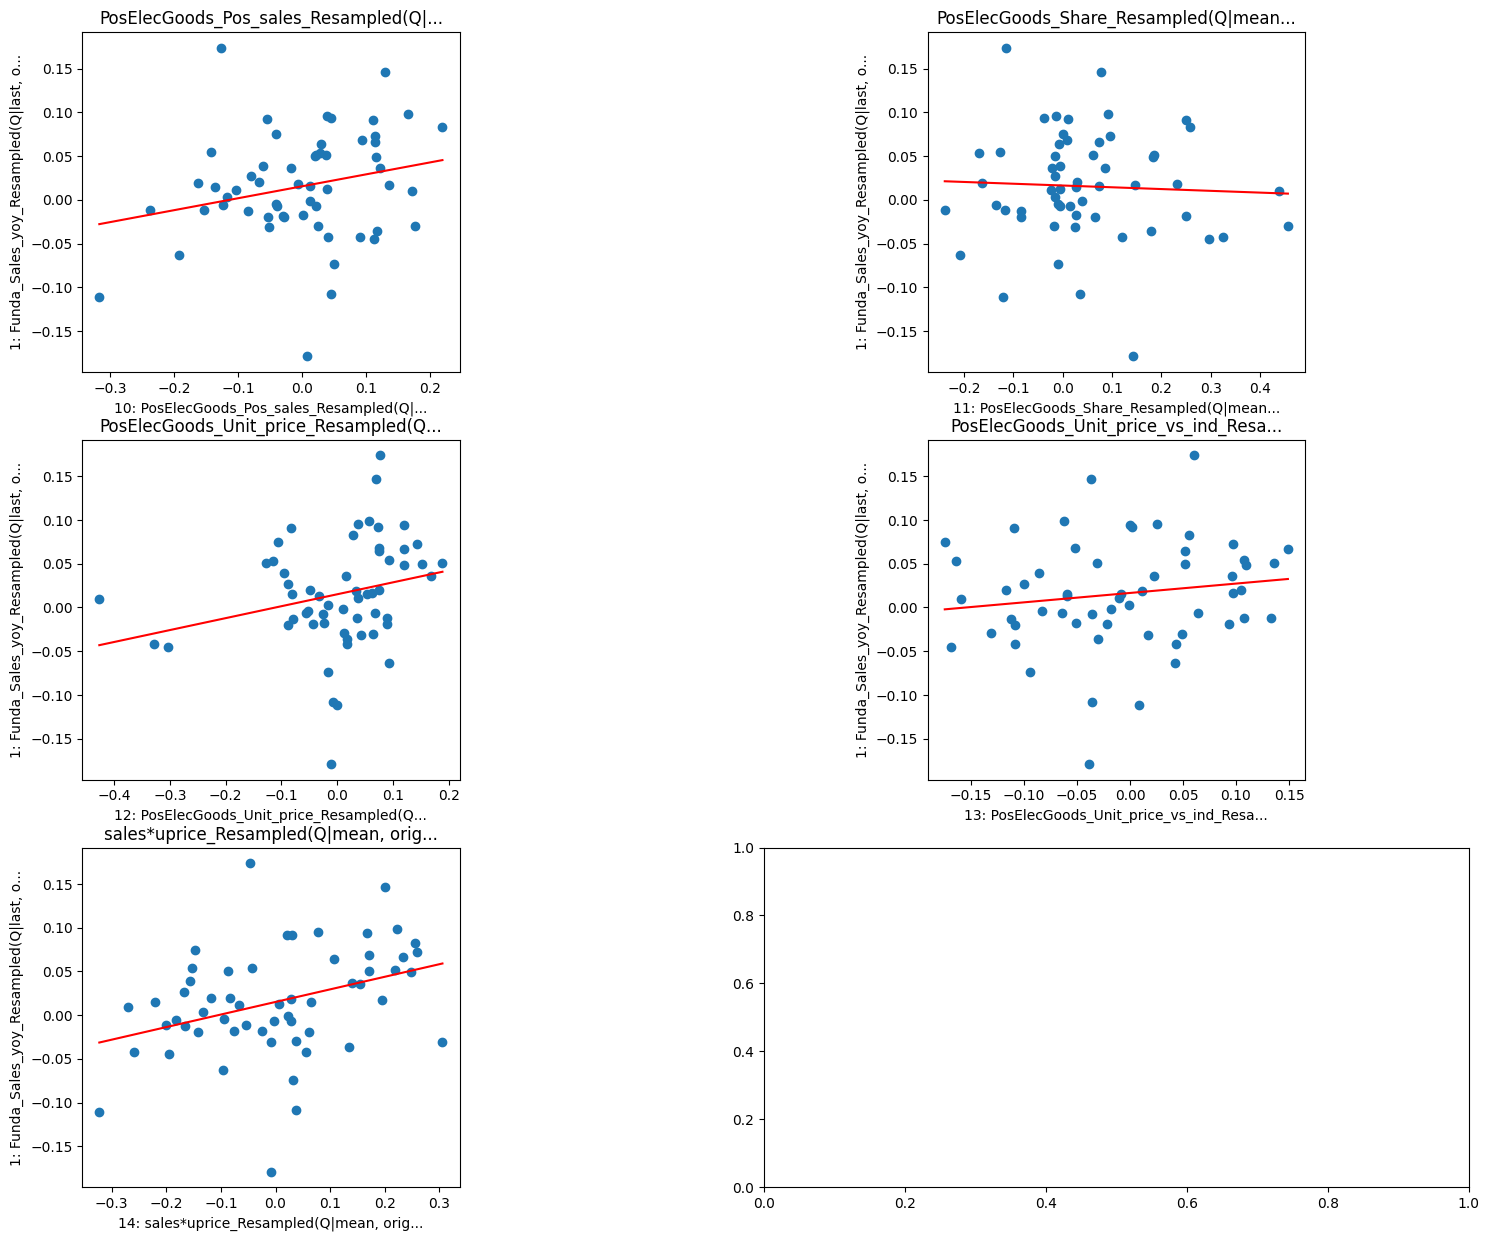

In [15]:
if not USE_MY_FUNDA:

    # Convert the POS data to YoY as well for comparison with the financial data.
    alt_Q_yoy_ids = sdh.transform.log_diff(periods=4, fields=alt_Q_ids).variable_ids

    # Plot the data to visually inspect its shape.
    sdh.show_scatter_one_target(
        target=sample_target,
        y=funda_Q_ids[0],
        X=alt_Q_yoy_ids,
        col_num=2,
        vname_len_limit=35
    )

    # Define the variables.
    vid_alt = sdh.transform.raw(data_id=data_id_alt).variable_ids\
        + sdh.transform.mul(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice").variable_ids
    alt_Q_shift_03_ids = sdh.transform.shift(fields=vid_alt, periods=3).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_04_ids = sdh.transform.shift(fields=vid_alt, periods=4).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_05_ids = sdh.transform.shift(fields=vid_alt, periods=5).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_06_ids = sdh.transform.shift(fields=vid_alt, periods=6).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_07_ids = sdh.transform.shift(fields=vid_alt, periods=7).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_08_ids = sdh.transform.shift(fields=vid_alt, periods=8).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_09_ids = sdh.transform.shift(fields=vid_alt, periods=9).resample(rule='Q', func='mean').variable_ids
    alt_Q_shift_12_ids = sdh.transform.shift(fields=vid_alt, periods=12).resample(rule='Q', func='mean').variable_ids


    # To address cases where trends might cause apparent correlations, create a variable with an additional lagged difference.
    sales_id = funda_Q_ids[0]
    sales_diff_id = sdh.transform.diff(fields=funda_Q_ids, periods=1).variable_ids[-1]
    

In [16]:
# Convert the data to year-over-year (YoY) changes and then calculate the correlation coefficients between sales and the alternative data.
alt_Q_shift_00_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_ids,          periods=4).variable_ids
alt_Q_shift_03_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_03_ids, periods=4).variable_ids
alt_Q_shift_04_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_04_ids, periods=4).variable_ids
alt_Q_shift_05_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_05_ids, periods=4).variable_ids
alt_Q_shift_06_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_06_ids, periods=4).variable_ids
alt_Q_shift_07_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_07_ids, periods=4).variable_ids
alt_Q_shift_08_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_08_ids, periods=4).variable_ids
alt_Q_shift_09_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_09_ids, periods=4).variable_ids
alt_Q_shift_12_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_12_ids, periods=4).variable_ids

# To address cases where trends might cause apparent correlations, also create variables with an additional lagged difference.
alt_Q_shift_00_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_ids,          periods=4).diff(periods=1).variable_ids
alt_Q_shift_03_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_03_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_04_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_04_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_05_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_05_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_06_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_06_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_07_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_07_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_08_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_08_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_09_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_09_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_12_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_12_ids, periods=4).diff(periods=1).variable_ids

#### Correlation Calculation

In [17]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=00'] = ade.compu_rho(alt_Q_shift_00_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=03'] = ade.compu_rho(alt_Q_shift_03_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=04'] = ade.compu_rho(alt_Q_shift_04_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=05'] = ade.compu_rho(alt_Q_shift_05_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=06'] = ade.compu_rho(alt_Q_shift_06_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=07'] = ade.compu_rho(alt_Q_shift_07_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=08'] = ade.compu_rho(alt_Q_shift_08_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=09'] = ade.compu_rho(alt_Q_shift_09_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=12'] = ade.compu_rho(alt_Q_shift_12_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=00_diff=1'] = ade.compu_rho(alt_Q_shift_00_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=03_diff=1'] = ade.compu_rho(alt_Q_shift_03_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=04_diff=1'] = ade.compu_rho(alt_Q_shift_04_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=05_diff=1'] = ade.compu_rho(alt_Q_shift_05_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=06_diff=1'] = ade.compu_rho(alt_Q_shift_06_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=07_diff=1'] = ade.compu_rho(alt_Q_shift_07_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=08_diff=1'] = ade.compu_rho(alt_Q_shift_08_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=09_diff=1'] = ade.compu_rho(alt_Q_shift_09_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=12_diff=1'] = ade.compu_rho(alt_Q_shift_12_logdiff_diff_ids, sales_diff_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,n_shift=00,n_shift=03,n_shift=04,n_shift=05,n_shift=06,n_shift=07,n_shift=08,n_shift=09,n_shift=12,n_shift=00_diff=1,n_shift=03_diff=1,n_shift=04_diff=1,n_shift=05_diff=1,n_shift=06_diff=1,n_shift=07_diff=1,n_shift=08_diff=1,n_shift=09_diff=1,n_shift=12_diff=1
sales*uprice,4.419871,3.867349,4.155552,3.876635,3.620575,3.612087,3.743074,3.362170,3.944505,6.067117,5.710304,5.646159,5.035571,4.755087,4.927017,4.354537,4.151083,5.530334
pos_sales,3.230455,2.822745,3.193368,2.971281,2.478163,2.567161,2.715457,2.493288,2.813557,4.643998,4.528631,4.819334,3.983943,3.955331,4.109877,3.163388,2.986775,3.952917
unit_price,2.905573,2.441230,2.990067,2.682825,2.318476,2.049171,2.647180,2.342878,2.574063,4.165601,4.045830,4.357250,3.668201,4.095851,3.891894,3.638605,3.547657,5.620642
unit_price_vs_ind,0.001091,-0.901375,-0.359605,-0.390035,-0.323414,-0.323269,-0.180948,-0.020067,-0.362486,0.744870,0.439588,1.230416,1.456911,2.047968,1.572284,0.589530,0.358036,0.933793
share,-0.625008,-1.469521,-0.419332,-0.887771,-0.829947,-0.837020,-1.391894,-1.161251,-1.089137,-0.050868,-0.263884,0.152852,-1.007696,-0.365258,-0.109306,-1.360463,-1.605986,-0.859411


##### Correlation values can also be calculated on a Ticker-by-Ticker basis
- Below, the top 5 TICKERs are selected, and their relationships are plotted.

In [18]:
rho_time = ade.compu_rho(
    alt_Q_shift_06_logdiff_diff_ids,
    sales_diff_id, by='TICKER',
    rename_features=features,
    min_nsample=30
)
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

/home/schiba/miniconda3/envs/inv/lib/python3.9/site-packages/pandas/core/nanops.py:1569: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



,pos_sales,share,unit_price,unit_price_vs_ind,sales*uprice
TICKER,,,,,
6676,5.843781,0.975900,2.331842,0.078864,4.376457
6955,4.512744,4.347149,1.978712,1.863809,5.201449
6930,4.172701,1.238276,0.525223,0.281991,3.407847
7962,3.091351,2.582110,1.824859,1.416967,2.439840
7733,3.062550,0.042193,1.006864,-1.938675,2.597677


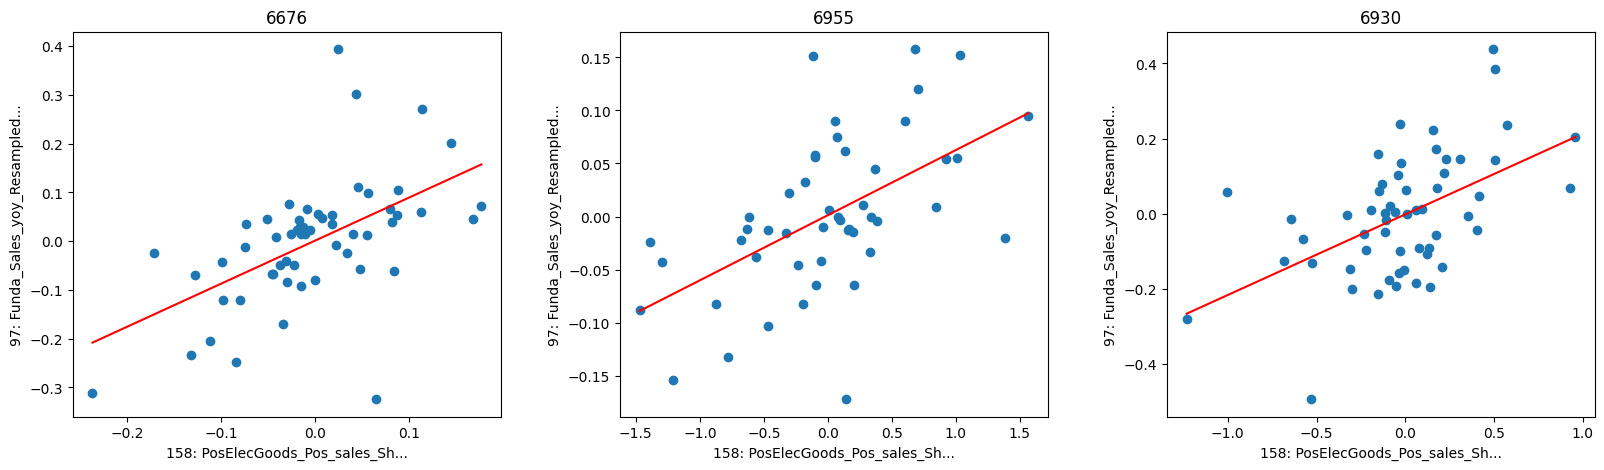

In [19]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_id,
    x=alt_Q_shift_06_logdiff_diff_ids[0],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=25,
)

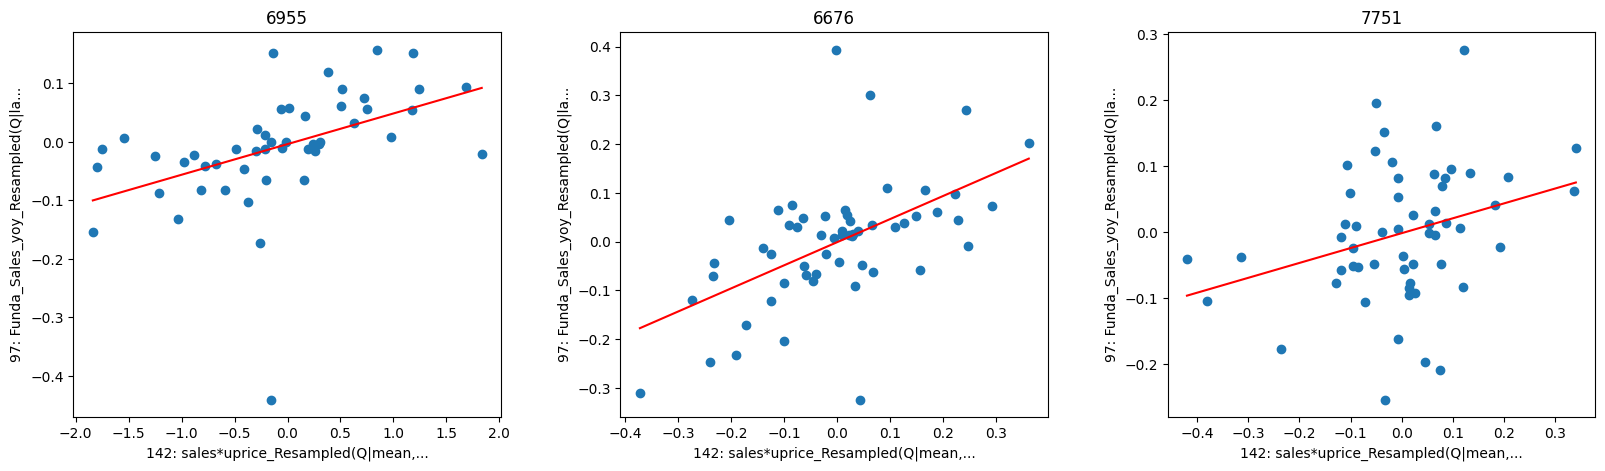

In [20]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('sales*uprice', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_id,
    x=alt_Q_shift_00_logdiff_diff_ids[4],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=30,
)

## Step 4: Quantile Backtest
- Based on the variables created in Step 3, various factors will be generated and calculations will be performed.
- Here, the 2-week moving average of the `sales*uprice` variable is selected as the factor value.
- In practice, you should vary hyperparameters such as the moving average period and shift intervals to ensure that the backtest results are not significantly affected.

In [21]:
if USE_MY_MKT:
    close_ret = sdh.transform\
        .resample(data_id=data_id_mkt, rule='D', fields='close', func='last')\
        .dropna(how='all')\
        .log_diff(periods=1, names='ret')\
        .variable_ids[0]
else:
    close_ret = sdh.transform.raw(data_id=data_id_mkt, fields='returns').variable_ids[0]

In [22]:
sma_period = 14
min_period = int(max(np.floor(sma_period * 5 / 7), 1))
proto_trans_vid = sdh.transform\
        .mul(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice")\
        .resample(rule='D', func='last')\
        .sma(periods=sma_period, min_periods=min_period)\
        .reindex(label=close_ret)\
        .log_diff(periods=252)\
        .shift(periods=8)\
        .variable_ids[0]

In [23]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [24]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature=proto_trans_vid,
    actual_return=close_ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.111865,0.007674,0.205380,0.037363,0.531127,23.186286,-0.779108,0.009849
#2,0.889561,0.061020,0.204661,0.298154,0.531969,39.282956,-0.561526,0.108669
#3,1.388436,0.095241,0.205282,0.463954,0.544588,23.987377,-0.492149,0.193521
#3-#1,1.276571,0.087568,0.113211,0.773495,0.529445,47.173663,-0.245130,0.357230
#3-#1(cost),0.932720,0.063981,0.113197,0.565219,0.523556,47.173663,-0.290893,0.219947
